In [5]:
import pandas as pd
from tqdm import tqdm
from functools import reduce
from tqdm import tqdm
from itertools import combinations


from src.data.dataloader_functions import load_processed_data
from src.utils.recovery_analysis_utils import *
from src.models.llm_call_helpers import *

# Load data

Load the videos

In [6]:
videos = pd.read_csv('data/bb_videos_title_around_declines1.csv')

videos

,index,channel_id,week,title
0,12471,UCzVw9odnihM5PgKSv5UnDPA,247,Most Funny Babies and Kids Playing in Water - ...
1,12472,UCzVw9odnihM5PgKSv5UnDPA,246,Kids and Babies Trying to do Exercises Funny...
2,12473,UCzVw9odnihM5PgKSv5UnDPA,246,Cute and Adorable Moments of kids meeting newb...
3,12474,UCzVw9odnihM5PgKSv5UnDPA,245,Cute Baby and His Daughter playing and Laughing
4,12475,UCzVw9odnihM5PgKSv5UnDPA,244,Kids and Babies Meeting Animals in Village and...
...,...,...,...,...
107612,72787994,UCs06q9pyRn8d8xy0NgzKPrA,216,Tay K Allegedly Started a new gang in Jail cal...
107613,72787995,UCs06q9pyRn8d8xy0NgzKPrA,216,YNW Melly being investigated for a THIRD Murde...
107614,72787996,UCs06q9pyRn8d8xy0NgzKPrA,215,Face To Face: Lil Reese x DJ Akademiks: Talks ...
107615,72901188,UCrwmu-gceGOmtZeuTsn7DlQ,193,The Black Eyed Peas - BIG LOVE


Load the results of the LLM

In [7]:
df_apology = pd.read_csv('data/bb_apology.csv', index_col=0)
df_clickbait = pd.read_csv('data/bb_clickbait.csv', index_col=0)
df_break = pd.read_csv('data/bb_break.csv', index_col=0)
df_comeback = pd.read_csv('data/bb_comeback.csv', index_col=0)
df_featuring = pd.read_csv('data/bb_featuring.csv', index_col=0)
df_decline_addressed = pd.read_csv('data/bb_decline_addressed.csv', index_col=0)

# Merge LLM results together

In [8]:
df_videos_llm = pd.concat(
    [
        videos,
        df_apology['apology'],
        df_clickbait['clickbait'],
        df_break['break'],
        df_comeback['comeback'],
        df_featuring['featuring'],
        df_decline_addressed['decline_addressed']
    ],
    axis=1
)

df_videos_llm

,index,channel_id,week,title,apology,clickbait,break,comeback,featuring,decline_addressed
0,12471,UCzVw9odnihM5PgKSv5UnDPA,247,Most Funny Babies and Kids Playing in Water - ...,False,True,False,False,False,False
1,12472,UCzVw9odnihM5PgKSv5UnDPA,246,Kids and Babies Trying to do Exercises Funny...,False,True,False,False,False,False
2,12473,UCzVw9odnihM5PgKSv5UnDPA,246,Cute and Adorable Moments of kids meeting newb...,False,True,False,False,False,False
3,12474,UCzVw9odnihM5PgKSv5UnDPA,245,Cute Baby and His Daughter playing and Laughing,False,False,False,False,False,False
4,12475,UCzVw9odnihM5PgKSv5UnDPA,244,Kids and Babies Meeting Animals in Village and...,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
107612,72787994,UCs06q9pyRn8d8xy0NgzKPrA,216,Tay K Allegedly Started a new gang in Jail cal...,False,True,False,False,False,False
107613,72787995,UCs06q9pyRn8d8xy0NgzKPrA,216,YNW Melly being investigated for a THIRD Murde...,False,True,False,False,False,False
107614,72787996,UCs06q9pyRn8d8xy0NgzKPrA,215,Face To Face: Lil Reese x DJ Akademiks: Talks ...,False,True,False,False,True,False
107615,72901188,UCrwmu-gceGOmtZeuTsn7DlQ,193,The Black Eyed Peas - BIG LOVE,False,False,False,False,False,False


# Analysis of the results

In [9]:
# Observation for each LLM results

llm_columns = ['apology', 'clickbait', 'break', 'comeback', 'featuring', 'decline_addressed']

for col in llm_columns:
    print(col)
    print(df_videos_llm[col].value_counts())
    print()

apology
apology
False    107419
True        198
Name: count, dtype: int64

clickbait
clickbait
True     78354
False    29262
To           1
Name: count, dtype: int64

break
break
False    107047
True        570
Name: count, dtype: int64

comeback
comeback
False    106714
True        903
Name: count, dtype: int64

featuring
featuring
False    103463
True       4150
I             1
I'm           1
Not           1
To            1
Name: count, dtype: int64

decline_addressed
decline_addressed
False    104940
True       2676
I             1
Name: count, dtype: int64



In [10]:
# Clean the results

def clean_result(result):
    if result == True or result == 'True':
        return int(1)
    elif result == False or result == 'False':
        return int(0)
    else:
        return None

for col in llm_columns:
    df_videos_llm[col] = df_videos_llm[col].apply(clean_result)

df_videos_llm

,index,channel_id,week,title,apology,clickbait,break,comeback,featuring,decline_addressed
0,12471,UCzVw9odnihM5PgKSv5UnDPA,247,Most Funny Babies and Kids Playing in Water - ...,0,1.0,0,0,0.0,0.0
1,12472,UCzVw9odnihM5PgKSv5UnDPA,246,Kids and Babies Trying to do Exercises Funny...,0,1.0,0,0,0.0,0.0
2,12473,UCzVw9odnihM5PgKSv5UnDPA,246,Cute and Adorable Moments of kids meeting newb...,0,1.0,0,0,0.0,0.0
3,12474,UCzVw9odnihM5PgKSv5UnDPA,245,Cute Baby and His Daughter playing and Laughing,0,0.0,0,0,0.0,0.0
4,12475,UCzVw9odnihM5PgKSv5UnDPA,244,Kids and Babies Meeting Animals in Village and...,0,1.0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
107612,72787994,UCs06q9pyRn8d8xy0NgzKPrA,216,Tay K Allegedly Started a new gang in Jail cal...,0,1.0,0,0,0.0,0.0
107613,72787995,UCs06q9pyRn8d8xy0NgzKPrA,216,YNW Melly being investigated for a THIRD Murde...,0,1.0,0,0,0.0,0.0
107614,72787996,UCs06q9pyRn8d8xy0NgzKPrA,215,Face To Face: Lil Reese x DJ Akademiks: Talks ...,0,1.0,0,0,1.0,0.0
107615,72901188,UCrwmu-gceGOmtZeuTsn7DlQ,193,The Black Eyed Peas - BIG LOVE,0,0.0,0,0,0.0,0.0


In [11]:
# Count the number of None values for each LLM result
null_counts = pd.DataFrame({
    'Column': llm_columns,
    'None Count': [df_videos_llm[col].isnull().sum() for col in llm_columns]
})
print(null_counts)

              Column  None Count
0            apology           0
1          clickbait           1
2              break           0
3           comeback           0
4          featuring           4
5  decline_addressed           1


Since the number of None values is very low, we can remove the corresponding videos from the dataset.

In [12]:
df_videos_llm = df_videos_llm.dropna()
df_videos_llm

,index,channel_id,week,title,apology,clickbait,break,comeback,featuring,decline_addressed
0,12471,UCzVw9odnihM5PgKSv5UnDPA,247,Most Funny Babies and Kids Playing in Water - ...,0,1.0,0,0,0.0,0.0
1,12472,UCzVw9odnihM5PgKSv5UnDPA,246,Kids and Babies Trying to do Exercises Funny...,0,1.0,0,0,0.0,0.0
2,12473,UCzVw9odnihM5PgKSv5UnDPA,246,Cute and Adorable Moments of kids meeting newb...,0,1.0,0,0,0.0,0.0
3,12474,UCzVw9odnihM5PgKSv5UnDPA,245,Cute Baby and His Daughter playing and Laughing,0,0.0,0,0,0.0,0.0
4,12475,UCzVw9odnihM5PgKSv5UnDPA,244,Kids and Babies Meeting Animals in Village and...,0,1.0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
107612,72787994,UCs06q9pyRn8d8xy0NgzKPrA,216,Tay K Allegedly Started a new gang in Jail cal...,0,1.0,0,0,0.0,0.0
107613,72787995,UCs06q9pyRn8d8xy0NgzKPrA,216,YNW Melly being investigated for a THIRD Murde...,0,1.0,0,0,0.0,0.0
107614,72787996,UCs06q9pyRn8d8xy0NgzKPrA,215,Face To Face: Lil Reese x DJ Akademiks: Talks ...,0,1.0,0,0,1.0,0.0
107615,72901188,UCrwmu-gceGOmtZeuTsn7DlQ,193,The Black Eyed Peas - BIG LOVE,0,0.0,0,0,0.0,0.0


In [13]:
# sum of all LLM results
sum_llm_results = df_videos_llm[llm_columns].sum(axis=0)

sum_llm_results

apology                198.0
clickbait            78351.0
break                  568.0
comeback               902.0
featuring             4150.0
decline_addressed     2675.0
dtype: float64

# LLM Results Analysis

Now that we have the clean results of the LLM, we can analyze them statistically.

In [14]:
llm_columns = ['apology', 'clickbait', 'break', 'comeback', 'featuring', 'decline_addressed']

# Compute the proportions for each strategy for all videos
proportions = pd.DataFrame({
    'Column': llm_columns,
    'Proportion of True (%)': [df_videos_llm[col].mean() * 100 for col in llm_columns]
}).round(2)

proportions

,Column,Proportion of True (%)
0,apology,0.18
1,clickbait,72.81
2,break,0.53
3,comeback,0.84
4,featuring,3.86
5,decline_addressed,2.49


# Preparation for Propensity Score Matching

We prepare necessary data to perform a propensity score matching to compare the recovery level of each decline with and without each strategy.

In [15]:
def get_sampled_declines_with_videos_after(df, df_videos):
    try:
        declines = pd.read_csv('data/sampled_bb_decline_events_with_videos.csv')
        print("Sampled declines with videos loaded from file.")
    except FileNotFoundError:
        print("File not found, computing the sampled declines with videos...")

        df = df.copy()

        def find_videos_after(row):
            channel_mask = df_videos['channel_id'] == row['Channel']
            left_mask = df_videos['week'] >= row['Start']
            right_mask = df_videos['week'] <= row['End'] + row['Duration']
            return df_videos[channel_mask & left_mask & right_mask]['index'].tolist()
            
        df['Videos_after'] = [[]] * len(df)

        for idx, row in tqdm(df.iterrows(), total=len(df)):
            df.at[idx, 'Videos_after'] = find_videos_after(row)

        declines = df

    declines['Videos_after'] = declines['Videos_after']

    return declines

In [16]:
df_bb_declines_original = pd.read_csv('data/bb_from_declined_events.csv')
df_channels = pd.read_csv('data/df_channels_en.tsv', sep='\t', usecols=['channel', 'category_cc'], index_col='channel')
df_data_processed = load_processed_data(usecols=['channel', 'week', 'subs', 'activity', 'views'])

In [17]:
df_bb_declines = df_bb_declines_original.copy()

# If the decline is longer than 4 months without recovery, we consider the YouTuber was not successful in handling it.
# Our aim is to find strategies that lead to quick recoveries, therefore taking more than 4 months would be considered unsuccessful.
RECOVERY_THRESHOLD = 4 * 4

# Add the decline outcome
df_bb_declines['Recovered'] = df_bb_declines['Duration'] < RECOVERY_THRESHOLD

# Split the tuple (decline start, decline end) into two separate columns
df_bb_declines['Event'] = df_bb_declines['Event'].apply(lambda s: [int(week_id) for week_id in s[1:-1].split(', ')])
df_bb_declines['Start'] = df_bb_declines['Event'].apply(lambda e: e[0])
df_bb_declines['End'] = df_bb_declines['Event'].apply(lambda e: e[1])
df_bb_declines.drop('Event', axis=1, inplace=True)

# Add the channel category
df_bb_declines['Category'] = df_bb_declines['Channel'].apply(lambda c: df_channels.loc[c]['category_cc'])

# Add the channel's subs at the start of the decline
decline_index = list(zip(df_bb_declines['Channel'], df_bb_declines['Start']))
df_bb_declines['Subs_start'] = df_data_processed.loc[decline_index, 'subs'].values

# Add the activity at the start of the decline
df_bb_declines['Activity_start'] = df_data_processed.loc[decline_index, 'activity'].values

# Add the channel's subs at the start of the decline
df_bb_declines['Views_start'] = df_data_processed.loc[decline_index, 'views'].values

print(f"Overall recovery rate: {df_bb_declines['Recovered'].mean():.2f}")

df_bb_declines.head()

df_bb_declines

Overall recovery rate: 0.46


,Channel,Duration,Mean_Number_of_Subscribers,Recovered,Start,End,Category,Subs_start,Activity_start,Views_start
0,UC1SqP7_RfOC9Jf9L_GRHANg,22,1.111359e+07,False,173,195,Music,1.174756e+07,0,5.055265e+09
1,UCLF-kfM8ZxHQ9lW_lpu_thw,19,2.932874e+06,False,190,209,Entertainment,3.209915e+06,23,4.307642e+09
2,UCLF-kfM8ZxHQ9lW_lpu_thw,16,2.932874e+06,False,228,244,Entertainment,3.396353e+06,23,4.616026e+09
3,UChGYKxkYdyi9e51dScmug6g,9,1.022885e+06,True,114,123,People & Blogs,1.008588e+06,2,2.802017e+07
4,UChGYKxkYdyi9e51dScmug6g,17,1.022885e+06,False,144,161,People & Blogs,1.063543e+06,1,3.419171e+07
...,...,...,...,...,...,...,...,...,...,...
2950,UCbW18JZRgko_mOGm5er8Yzg,22,2.277880e+07,False,170,192,Music,2.363792e+07,0,7.988348e+09
2951,UCevNJDNNIKmG13YmTqLnZ-A,9,1.659769e+06,True,141,150,Howto & Style,1.669121e+06,3,1.476181e+08
2952,UCevNJDNNIKmG13YmTqLnZ-A,18,1.659769e+06,False,157,175,Howto & Style,1.678545e+06,1,1.406823e+08
2953,UCy6kyFxaMqGtpE3pQTflK8A,17,1.322269e+06,False,117,134,Film and Animation,1.066099e+06,10,2.981150e+08


In [18]:
# Add the declines with the indices of the corresponding videos
df_bb_declines = get_sampled_declines_with_videos_after(df_bb_declines, df_videos_llm)

df_bb_declines

File not found, computing the sampled declines with videos...


100%|██████████| 2955/2955 [00:08<00:00, 348.82it/s]


,Channel,Duration,Mean_Number_of_Subscribers,Recovered,Start,End,Category,Subs_start,Activity_start,Views_start,Videos_after
0,UC1SqP7_RfOC9Jf9L_GRHANg,22,1.111359e+07,False,173,195,Music,1.174756e+07,0,5.055265e+09,[]
1,UCLF-kfM8ZxHQ9lW_lpu_thw,19,2.932874e+06,False,190,209,Entertainment,3.209915e+06,23,4.307642e+09,"[41752053, 41752054, 41752055, 41752056, 41752..."
2,UCLF-kfM8ZxHQ9lW_lpu_thw,16,2.932874e+06,False,228,244,Entertainment,3.396353e+06,23,4.616026e+09,"[41751971, 41751972, 41751973, 41751974, 41751..."
3,UChGYKxkYdyi9e51dScmug6g,9,1.022885e+06,True,114,123,People & Blogs,1.008588e+06,2,2.802017e+07,"[13614545, 13614546, 13614547, 13614548, 13614..."
4,UChGYKxkYdyi9e51dScmug6g,17,1.022885e+06,False,144,161,People & Blogs,1.063543e+06,1,3.419171e+07,"[13614527, 13614528, 13614529, 13614530, 13614..."
...,...,...,...,...,...,...,...,...,...,...,...
2950,UCbW18JZRgko_mOGm5er8Yzg,22,2.277880e+07,False,170,192,Music,2.363792e+07,0,7.988348e+09,[]
2951,UCevNJDNNIKmG13YmTqLnZ-A,9,1.659769e+06,True,141,150,Howto & Style,1.669121e+06,3,1.476181e+08,"[16154283, 16154284, 16154289, 16154290, 16154..."
2952,UCevNJDNNIKmG13YmTqLnZ-A,18,1.659769e+06,False,157,175,Howto & Style,1.678545e+06,1,1.406823e+08,"[16154272, 16154273, 16154274, 16154275, 16154..."
2953,UCy6kyFxaMqGtpE3pQTflK8A,17,1.322269e+06,False,117,134,Film and Animation,1.066099e+06,10,2.981150e+08,"[16584193, 16584194, 16584195, 16584196, 16584..."


In [19]:
# Extract the result for the LLM for each strategy for each decline
llm_columns = ['apology', 'clickbait', 'break', 'comeback', 'featuring', 'decline_addressed']
df_bb_declines_llm = df_bb_declines.copy()

for col in llm_columns:
    df_bb_declines_llm[col] = [0] * len(df_bb_declines_llm)

df_bb_declines_llm

,Channel,Duration,Mean_Number_of_Subscribers,Recovered,Start,End,Category,Subs_start,Activity_start,Views_start,Videos_after,apology,clickbait,break,comeback,featuring,decline_addressed
0,UC1SqP7_RfOC9Jf9L_GRHANg,22,1.111359e+07,False,173,195,Music,1.174756e+07,0,5.055265e+09,[],0,0,0,0,0,0
1,UCLF-kfM8ZxHQ9lW_lpu_thw,19,2.932874e+06,False,190,209,Entertainment,3.209915e+06,23,4.307642e+09,"[41752053, 41752054, 41752055, 41752056, 41752...",0,0,0,0,0,0
2,UCLF-kfM8ZxHQ9lW_lpu_thw,16,2.932874e+06,False,228,244,Entertainment,3.396353e+06,23,4.616026e+09,"[41751971, 41751972, 41751973, 41751974, 41751...",0,0,0,0,0,0
3,UChGYKxkYdyi9e51dScmug6g,9,1.022885e+06,True,114,123,People & Blogs,1.008588e+06,2,2.802017e+07,"[13614545, 13614546, 13614547, 13614548, 13614...",0,0,0,0,0,0
4,UChGYKxkYdyi9e51dScmug6g,17,1.022885e+06,False,144,161,People & Blogs,1.063543e+06,1,3.419171e+07,"[13614527, 13614528, 13614529, 13614530, 13614...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,UCbW18JZRgko_mOGm5er8Yzg,22,2.277880e+07,False,170,192,Music,2.363792e+07,0,7.988348e+09,[],0,0,0,0,0,0
2951,UCevNJDNNIKmG13YmTqLnZ-A,9,1.659769e+06,True,141,150,Howto & Style,1.669121e+06,3,1.476181e+08,"[16154283, 16154284, 16154289, 16154290, 16154...",0,0,0,0,0,0
2952,UCevNJDNNIKmG13YmTqLnZ-A,18,1.659769e+06,False,157,175,Howto & Style,1.678545e+06,1,1.406823e+08,"[16154272, 16154273, 16154274, 16154275, 16154...",0,0,0,0,0,0
2953,UCy6kyFxaMqGtpE3pQTflK8A,17,1.322269e+06,False,117,134,Film and Animation,1.066099e+06,10,2.981150e+08,"[16584193, 16584194, 16584195, 16584196, 16584...",0,0,0,0,0,0


In [20]:
def check_cols(decline):
    for col in llm_columns:
        decline[col] = any(df_videos_llm[df_videos_llm["index"].isin(decline['Videos_after'])][col] > 0)

    return decline

df_bb_declines_llm = df_bb_declines_llm.apply(check_cols, axis=1)

In [21]:
print(df_bb_declines_llm[llm_columns].value_counts())

apology  clickbait  break  comeback  featuring  decline_addressed
False    True       False  False     False      False                908
         False      False  False     False      False                658
         True       False  False     True       False                356
                                     False      True                 158
                                     True       True                 156
                           True      True       True                 116
                                                False                 72
                    True   True      True       True                  65
                           False     True       True                  65
                                     False      True                  60
                    False  True      False      False                 57
True     True       True   True      True       True                  52
False    True       False  True      False      True      

In [22]:
# Save to file
df_bb_declines_llm.to_csv('data/bb_declines_with_llm.csv')

# Propensity Score Matching

In [23]:
# Load the file
df_bb_declines_llm = pd.read_csv('data/bb_declines_with_llm.csv', index_col=0)

df_bb_declines_llm

,Channel,Duration,Mean_Number_of_Subscribers,Recovered,Start,End,Category,Subs_start,Activity_start,Views_start,Videos_after,apology,clickbait,break,comeback,featuring,decline_addressed
0,UC1SqP7_RfOC9Jf9L_GRHANg,22,1.111359e+07,False,173,195,Music,1.174756e+07,0,5.055265e+09,[],False,False,False,False,False,False
1,UCLF-kfM8ZxHQ9lW_lpu_thw,19,2.932874e+06,False,190,209,Entertainment,3.209915e+06,23,4.307642e+09,"[41752053, 41752054, 41752055, 41752056, 41752...",False,True,False,False,False,False
2,UCLF-kfM8ZxHQ9lW_lpu_thw,16,2.932874e+06,False,228,244,Entertainment,3.396353e+06,23,4.616026e+09,"[41751971, 41751972, 41751973, 41751974, 41751...",False,True,False,False,False,False
3,UChGYKxkYdyi9e51dScmug6g,9,1.022885e+06,True,114,123,People & Blogs,1.008588e+06,2,2.802017e+07,"[13614545, 13614546, 13614547, 13614548, 13614...",False,True,False,False,False,False
4,UChGYKxkYdyi9e51dScmug6g,17,1.022885e+06,False,144,161,People & Blogs,1.063543e+06,1,3.419171e+07,"[13614527, 13614528, 13614529, 13614530, 13614...",False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,UCbW18JZRgko_mOGm5er8Yzg,22,2.277880e+07,False,170,192,Music,2.363792e+07,0,7.988348e+09,[],False,False,False,False,False,False
2951,UCevNJDNNIKmG13YmTqLnZ-A,9,1.659769e+06,True,141,150,Howto & Style,1.669121e+06,3,1.476181e+08,"[16154283, 16154284, 16154289, 16154290, 16154...",False,True,False,False,False,False
2952,UCevNJDNNIKmG13YmTqLnZ-A,18,1.659769e+06,False,157,175,Howto & Style,1.678545e+06,1,1.406823e+08,"[16154272, 16154273, 16154274, 16154275, 16154...",False,False,False,False,False,False
2953,UCy6kyFxaMqGtpE3pQTflK8A,17,1.322269e+06,False,117,134,Film and Animation,1.066099e+06,10,2.981150e+08,"[16584193, 16584194, 16584195, 16584196, 16584...",False,True,False,False,True,False


In [24]:
def propensity_score_matching(df, treatments, to_drop):
    for treatment, dropped in zip(treatments, to_drop):
        # Try to load the matches from the file, otherwise compute them
        print(df.drop(dropped, axis=1).columns)

        matches = get_matches(treatment=treatment, declines=df.drop(dropped, axis=1), verbose=False)

        print(f"{treatment} matches :", matches)

        # Flatten
        matches = [index for match in matches for index in match]

        # Get the matched declines
        df_matched = df.loc[matches]

        plot_treatment_effect(df_matched, treatment)

Index(['Channel', 'Duration', 'Mean_Number_of_Subscribers', 'Recovered',
       'Start', 'End', 'Category', 'Subs_start', 'Activity_start',
       'Views_start', 'apology', 'clickbait', 'break', 'comeback', 'featuring',
       'decline_addressed'],
      dtype='object')
Matches loaded from file for treatment apology.
apology matches : [(1716, 20), (98, 22), (871, 34), (1814, 35), (1100, 69), (2026, 73), (249, 93), (179, 96), (2405, 97), (2194, 112), (2821, 117), (2807, 122), (1330, 131), (1920, 144), (593, 145), (2453, 165), (2035, 192), (2939, 194), (2883, 195), (2558, 245), (2725, 291), (942, 362), (2711, 373), (2649, 415), (2533, 416), (1876, 467), (929, 479), (2749, 488), (2904, 502), (681, 503), (1969, 535), (1919, 543), (143, 544), (2813, 553), (2810, 596), (1051, 599), (1163, 612), (2744, 639), (1577, 643), (788, 651), (429, 740), (548, 765), (575, 766), (1645, 779), (1959, 785), (2081, 787), (1461, 789), (1586, 820), (32, 827), (354, 828), (516, 829), (305, 832), (2034, 874), (

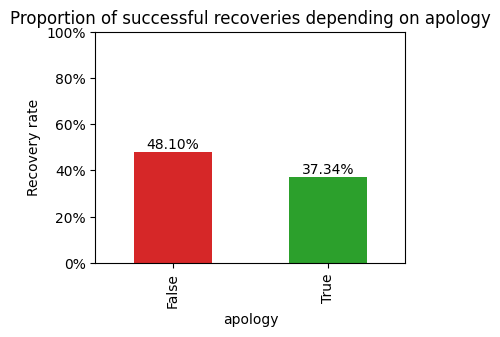

Index(['Channel', 'Duration', 'Mean_Number_of_Subscribers', 'Recovered',
       'Start', 'End', 'Category', 'Subs_start', 'Activity_start',
       'Views_start', 'apology', 'clickbait', 'break', 'comeback', 'featuring',
       'decline_addressed'],
      dtype='object')
Matches loaded from file for treatment clickbait.
clickbait matches : [(2275, 3), (2732, 4), (710, 7), (1884, 12), (756, 14), (1357, 15), (474, 16), (2802, 17), (2888, 26), (2161, 27), (1265, 29), (1701, 41), (1075, 43), (2397, 44), (2254, 45), (440, 46), (2630, 48), (132, 51), (2149, 52), (134, 53), (2387, 54), (1585, 77), (1333, 80), (459, 114), (2565, 115), (2866, 116), (2467, 125), (610, 127), (631, 128), (341, 130), (2867, 141), (1926, 142), (10, 147), (782, 148), (410, 150), (2086, 154), (1279, 160), (793, 161), (232, 164), (1657, 166), (2220, 168), (795, 169), (1286, 181), (138, 182), (1373, 184), (1003, 197), (107, 198), (1374, 203), (2286, 211), (1530, 222), (2227, 234), (1192, 236), (257, 237), (2464, 238), (2

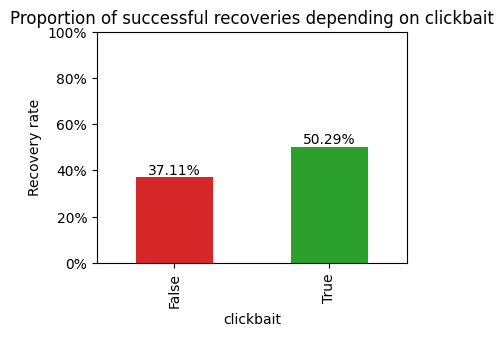

Index(['Channel', 'Duration', 'Mean_Number_of_Subscribers', 'Recovered',
       'Start', 'End', 'Category', 'Subs_start', 'Activity_start',
       'Views_start', 'apology', 'clickbait', 'break', 'comeback', 'featuring',
       'decline_addressed'],
      dtype='object')
Matches loaded from file for treatment break.
break matches : [(2521, 19), (612, 20), (890, 21), (291, 22), (263, 32), (2723, 33), (1246, 34), (488, 35), (457, 36), (2647, 37), (2070, 38), (405, 55), (1917, 56), (312, 62), (776, 68), (599, 69), (1962, 73), (637, 75), (613, 81), (2278, 82), (557, 93), (2847, 94), (1323, 95), (2156, 96), (1462, 97), (1147, 98), (516, 99), (2893, 104), (1491, 117), (2092, 122), (2448, 144), (2327, 145), (332, 170), (2909, 178), (2231, 179), (2742, 186), (63, 188), (766, 192), (1288, 193), (112, 194), (165, 195), (1420, 196), (1766, 245), (1971, 249), (600, 264), (818, 278), (817, 333), (90, 350), (489, 352), (2194, 354), (761, 373), (2393, 378), (1134, 383), (2790, 391), (1977, 392), (362,

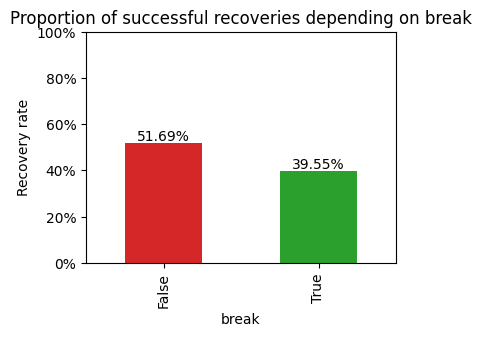

Index(['Channel', 'Duration', 'Mean_Number_of_Subscribers', 'Recovered',
       'Start', 'End', 'Category', 'Subs_start', 'Activity_start',
       'Views_start', 'apology', 'clickbait', 'break', 'comeback', 'featuring',
       'decline_addressed'],
      dtype='object')
Matches loaded from file for treatment comeback.
comeback matches : [(2457, 18), (2530, 19), (2027, 20), (1295, 21), (373, 32), (921, 33), (209, 34), (820, 35), (849, 39), (392, 55), (2243, 56), (467, 59), (2240, 60), (2587, 61), (1285, 68), (2739, 73), (1962, 85), (1165, 94), (1999, 98), (1319, 104), (1362, 120), (2300, 122), (1023, 131), (516, 144), (461, 145), (1968, 156), (1963, 170), (372, 171), (609, 175), (1059, 178), (2883, 179), (2292, 180), (2394, 192), (195, 193), (2766, 194), (604, 208), (2832, 230), (1180, 248), (589, 249), (2844, 251), (1914, 252), (2354, 258), (218, 261), (585, 269), (1845, 288), (984, 304), (1284, 305), (1318, 307), (899, 309), (2272, 310), (263, 319), (1100, 329), (452, 330), (1601, 332

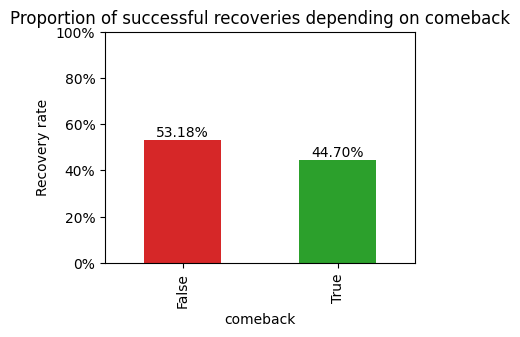

Index(['Channel', 'Duration', 'Mean_Number_of_Subscribers', 'Recovered',
       'Start', 'End', 'Category', 'Subs_start', 'Activity_start',
       'Views_start', 'apology', 'clickbait', 'break', 'comeback', 'featuring',
       'decline_addressed'],
      dtype='object')
Matches loaded from file for treatment featuring.
featuring matches : [(2268, 6), (57, 12), (2634, 20), (1061, 21), (71, 22), (912, 26), (1841, 27), (849, 28), (173, 29), (2725, 34), (2810, 35), (1106, 36), (1100, 37), (2475, 42), (1294, 43), (1028, 55), (2192, 56), (262, 59), (1407, 60), (186, 61), (1062, 62), (2860, 69), (977, 73), (2198, 74), (2544, 76), (2598, 85), (385, 87), (2830, 88), (1151, 93), (1059, 94), (373, 95), (2579, 96), (2627, 97), (2281, 98), (1815, 99), (2306, 100), (2774, 101), (1526, 104), (982, 112), (2276, 116), (397, 117), (1481, 119), (14, 120), (2155, 124), (2173, 126), (924, 128), (1109, 137), (1547, 143), (2563, 145), (2679, 156), (896, 157), (2061, 158), (1825, 159), (2046, 161), (32, 170),

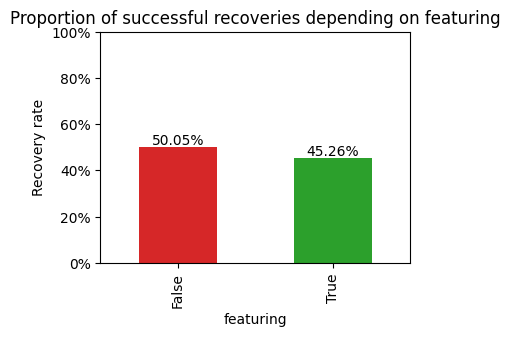

Index(['Channel', 'Duration', 'Mean_Number_of_Subscribers', 'Recovered',
       'Start', 'End', 'Category', 'Subs_start', 'Activity_start',
       'Views_start', 'apology', 'clickbait', 'break', 'comeback', 'featuring',
       'decline_addressed'],
      dtype='object')
Matches loaded from file for treatment decline_addressed.
decline_addressed matches : [(268, 19), (369, 20), (1811, 21), (1086, 22), (367, 32), (1489, 33), (625, 34), (248, 35), (671, 36), (1824, 37), (777, 38), (2643, 42), (1524, 50), (703, 55), (1866, 56), (1838, 57), (2087, 59), (2708, 60), (1930, 62), (2543, 63), (1490, 65), (2429, 66), (430, 67), (1155, 68), (442, 69), (1780, 70), (1344, 71), (2043, 72), (1295, 73), (2666, 74), (2212, 75), (734, 79), (2700, 81), (2095, 82), (854, 84), (1199, 85), (707, 86), (1293, 90), (1173, 91), (1102, 93), (2546, 94), (1108, 95), (500, 96), (857, 97), (2945, 98), (1169, 99), (88, 101), (2559, 102), (1206, 104), (2506, 105), (2775, 112), (1535, 120), (2128, 122), (2012, 124), (22

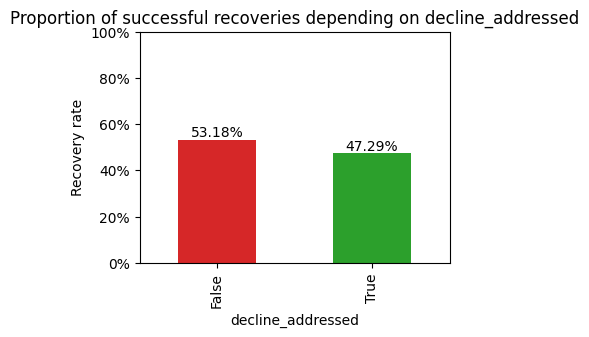

In [25]:
# The variables to be used for the matching
# Treatments in the same array will be plotted together
TREATMENTS = [ 					
    'apology',
    'clickbait',
    'break',
    'comeback',
    'featuring',
    'decline_addressed'
]

TO_DROP = [['Videos_after'] for _ in TREATMENTS]

propensity_score_matching(df_bb_declines_llm, TREATMENTS, TO_DROP)

# Analysis of the strategies 

In [26]:
strategies = ['apology', 'clickbait', 'break', 'comeback', 'featuring', 'decline_addressed']

# Compute the proportions for each strategy for all videos
proportions = pd.DataFrame({
    'Column': strategies,
    'Proportion (%)': [df_bb_declines_llm[col].sum()/len(df_bb_declines_llm) * 100 for col in strategies]
}).round(2)

proportions

,Column,Proportion (%)
0,apology,5.35
1,clickbait,76.38
2,break,11.98
3,comeback,15.97
4,featuring,33.20
5,decline_addressed,28.76


In [27]:
# Compute the recovery rates for each strategy
reco_rates = {'Strategy': [], 'Recovery Rate (%)': []}

# Compute recovery rate for each strategy
for strategy in strategies:
    if strategy in df_bb_declines_llm.columns:  # Ensure the column exists        
        # Compute recovery rate (mean of 'Recovered' values multiplied by 100 for percentage)
        recovery_rate = df_bb_declines_llm.groupby(strategy)['Recovered'].mean() * 100
        
        # Append results to the dictionary
        reco_rates['Strategy'].append(strategy)
        reco_rates['Recovery Rate (%)'].append(round(recovery_rate[True], 2) if True in recovery_rate.index else 0)

# Convert the dictionary into a DataFrame
df_recovery_rates = pd.DataFrame(reco_rates)

# Sort the DataFrame by Recovery Rate in descending order
# df_recovery_rates = df_recovery_rates.sort_values(by='Recovery Rate (%)', ascending=False)

df_recovery_rates

,Strategy,Recovery Rate (%)
0,apology,37.34
1,clickbait,49.31
2,break,39.55
3,comeback,44.70
4,featuring,45.26
5,decline_addressed,47.29


In [28]:
# Compute the proportions for each exclusive strategy
exclusive_proportions = pd.DataFrame({
    'Column': strategies,
    'Proportion (%)': [(df_bb_declines_llm[(df_bb_declines_llm[strategies].drop(col, axis=1) == 0).all(axis=1)][col].sum()/len(df_bb_declines_llm))*100 for col in strategies]
}).round(2)

exclusive_proportions

,Column,Proportion (%)
0,apology,0.00
1,clickbait,30.73
2,break,0.00
3,comeback,0.07
4,featuring,1.25
5,decline_addressed,0.00


In [40]:
exclusive_reco_rates = {'Strategy': [], 'Recovery Rate (%)': []}

# Compute recovery rate for each strategy
for strategy in strategies:
    if strategy in df_bb_declines_llm.columns:  # Ensure the column exists
        # Filter rows where all other columns are 0
        filtered_data = df_bb_declines_llm[(df_bb_declines_llm[strategies].drop(strategy, axis=1) == 0).all(axis=1)]
        
        # Compute recovery rate (mean of 'Recovered' values multiplied by 100 for percentage)
        recovery_rate = filtered_data.groupby(strategy)['Recovered'].mean() * 100
        
        # Append results to the dictionary
        exclusive_reco_rates['Strategy'].append(strategy)
        exclusive_reco_rates['Recovery Rate (%)'].append(round(recovery_rate[True], 2) if True in recovery_rate.index else 0)

# Convert the dictionary into a DataFrame
df_exclusive_recovery_rates = pd.DataFrame(exclusive_reco_rates)

# Sort the DataFrame by Recovery Rate in descending order
# df_recovery_rates = df_recovery_rates.sort_values(by='Recovery Rate (%)', ascending=False)

df_exclusive_recovery_rates

,Strategy,Recovery Rate (%)
0,apology,0.00
1,clickbait,52.20
2,break,0.00
3,comeback,50.00
4,featuring,18.92
5,decline_addressed,0.00


# Preparation for combinations of the strategies analysis

In [30]:
llm_columns = ['apology', 'clickbait', 'break', 'comeback', 'featuring', 'decline_addressed']

# Iterate through all combinations of the LLM columns
for i in range(2, len(llm_columns) + 1):  # Start with combinations of 2 columns
    for combo in combinations(llm_columns, i):
        # Create a new column name based on the combination
        col_name = '_&_'.join(combo)
        
        # Compute the AND operation: True if all are True, else False
        df_bb_declines_llm[col_name] = df_bb_declines_llm[list(combo)].all(axis=1)

# Analysis of the combinations of the strategies

We analize the results of the combinations of the strategies with results determined by the LLM.

In [31]:
TREATMENTS = [
    'apology_&_clickbait',
    'apology_&_break',
    'apology_&_comeback',
    'apology_&_featuring',
    'apology_&_decline_addressed',
    'clickbait_&_break',
    'clickbait_&_comeback',
    'clickbait_&_featuring',
    'clickbait_&_decline_addressed',
    'break_&_comeback',
    'break_&_featuring',
    'break_&_decline_addressed',
    'comeback_&_featuring',
    'comeback_&_decline_addressed',
    'featuring_&_decline_addressed',
    'apology_&_clickbait_&_break',
    'apology_&_clickbait_&_comeback',
    'apology_&_clickbait_&_featuring',
    'apology_&_clickbait_&_decline_addressed',
    'apology_&_break_&_comeback',
    'apology_&_break_&_featuring',
    'apology_&_break_&_decline_addressed',
    'apology_&_comeback_&_featuring',
    'apology_&_comeback_&_decline_addressed',
    'apology_&_featuring_&_decline_addressed',
    'clickbait_&_break_&_comeback',
    'clickbait_&_break_&_featuring',
    'clickbait_&_break_&_decline_addressed',
    'clickbait_&_comeback_&_featuring',
    'clickbait_&_comeback_&_decline_addressed',
    'clickbait_&_featuring_&_decline_addressed',
    'break_&_comeback_&_featuring',
    'break_&_comeback_&_decline_addressed',
    'break_&_featuring_&_decline_addressed',
    'comeback_&_featuring_&_decline_addressed',
    'apology_&_clickbait_&_break_&_comeback',
    'apology_&_clickbait_&_break_&_featuring',
    'apology_&_clickbait_&_break_&_decline_addressed',
    'apology_&_clickbait_&_comeback_&_featuring',
    'apology_&_clickbait_&_comeback_&_decline_addressed',
    'apology_&_clickbait_&_featuring_&_decline_addressed',
    'apology_&_break_&_comeback_&_featuring',
    'apology_&_break_&_comeback_&_decline_addressed',
    'apology_&_break_&_featuring_&_decline_addressed',
    'apology_&_comeback_&_featuring_&_decline_addressed',
    'clickbait_&_break_&_comeback_&_featuring',
    'clickbait_&_break_&_comeback_&_decline_addressed',
    'clickbait_&_break_&_featuring_&_decline_addressed',
    'clickbait_&_comeback_&_featuring_&_decline_addressed',
    'break_&_comeback_&_featuring_&_decline_addressed',
    'apology_&_clickbait_&_break_&_comeback_&_featuring',
    'apology_&_clickbait_&_break_&_comeback_&_decline_addressed',
    'apology_&_clickbait_&_break_&_featuring_&_decline_addressed',
    'apology_&_clickbait_&_comeback_&_featuring_&_decline_addressed',
    'apology_&_break_&_comeback_&_featuring_&_decline_addressed',
    'clickbait_&_break_&_comeback_&_featuring_&_decline_addressed',
    'apology_&_clickbait_&_break_&_comeback_&_featuring_&_decline_addressed'
]

In [32]:
# Compute the proportion for each combination of strategies
combo_proportions = pd.DataFrame({
    'Column': TREATMENTS,
    'Proportion (%)': [df_bb_declines_llm[col].sum()/len(df_bb_declines_llm) * 100 for col in TREATMENTS]
}).round(2)

combo_proportions

,Column,Proportion (%)
0,apology_&_clickbait,5.35
1,apology_&_break,3.99
2,apology_&_comeback,2.74
3,apology_&_featuring,3.69
4,apology_&_decline_addressed,5.14
5,clickbait_&_break,11.95
6,clickbait_&_comeback,15.91
7,clickbait_&_featuring,31.95
8,clickbait_&_decline_addressed,28.73
9,break_&_comeback,5.79


In [33]:
# Compute the receovery rate for each combination of strategies
combo_reco_rates = {'Strategy': [], 'Recovery Rate (%)': []}

# Compute recovery rate for each strategy
for strategy in TREATMENTS:
    if strategy in df_bb_declines_llm.columns:  # Ensure the column exists        
        # Compute recovery rate (mean of 'Recovered' values multiplied by 100 for percentage)
        recovery_rate = df_bb_declines_llm.groupby(strategy)['Recovered'].mean() * 100
        
        # Append results to the dictionary
        combo_reco_rates['Strategy'].append(strategy)
        combo_reco_rates['Recovery Rate (%)'].append(round(recovery_rate[True], 2) if True in recovery_rate.index else 0)

# Convert the dictionary into a DataFrame
df_combo_recovery_rates = pd.DataFrame(combo_reco_rates)

# Sort the DataFrame by Recovery Rate in descending order
# df_recovery_rates = df_recovery_rates.sort_values(by='Recovery Rate (%)', ascending=False)

df_combo_recovery_rates

,Strategy,Recovery Rate (%)
0,apology_&_clickbait,37.34
1,apology_&_break,33.90
2,apology_&_comeback,35.80
3,apology_&_featuring,33.94
4,apology_&_decline_addressed,36.84
5,clickbait_&_break,39.38
6,clickbait_&_comeback,44.68
7,clickbait_&_featuring,46.29
8,clickbait_&_decline_addressed,47.23
9,break_&_comeback,38.60


In [39]:
def get_combination_strategies(combination):
    """
    Extracts the strategies from a combination string.
    
    Parameters:
    - combination (str): Combination string of strategies separated by '_&_'
    
    Returns:
    - combination_strategies (list): List of strategies in the combination
    """

    # Extract the strategies from a combination 'strategy1_&_strategy2_&_...'
    combination_strategies = combination.split('_&_')

    return combination_strategies

print(get_combination_strategies('apology_&_decline_addressed_&_break'))

['apology', 'decline_addressed', 'break']


In [36]:
exclusive_combo_proportions = pd.DataFrame({
    'Column': TREATMENTS,
    'Proportion': [(df_bb_declines_llm[(df_bb_declines_llm[llm_columns].drop(get_combination_strategies(col), axis=1) == 0).all(axis=1)][col].sum()/len(df_bb_declines_llm))*100 for col in TREATMENTS]
}).round(3)

exclusive_combo_proportions

,Column,Proportion
0,apology_&_clickbait,0.068
1,apology_&_break,0.000
2,apology_&_comeback,0.000
3,apology_&_featuring,0.000
4,apology_&_decline_addressed,0.000
5,clickbait_&_break,0.135
6,clickbait_&_comeback,1.929
7,clickbait_&_featuring,12.047
8,clickbait_&_decline_addressed,5.347
9,break_&_comeback,0.000


In [38]:
exclusive_combo_reco_rates = {'Strategy': [], 'Recovery Rate (%)': []}

# Compute recovery rate for each strategy
for strategy in TREATMENTS:
    if strategy in df_bb_declines_llm.columns:  # Ensure the column exists
        # Filter rows where all other columns are 0
        filtered_data = df_bb_declines_llm[(df_bb_declines_llm[llm_columns].drop(get_combination_strategies(strategy), axis=1) == 0).all(axis=1)]
        
        # Compute recovery rate (mean of 'Recovered' values multiplied by 100 for percentage)
        recovery_rate = filtered_data.groupby(strategy)['Recovered'].mean() * 100
        
        # Append results to the dictionary
        exclusive_combo_reco_rates['Strategy'].append(strategy)
        exclusive_combo_reco_rates['Recovery Rate (%)'].append(round(recovery_rate[True], 2) if True in recovery_rate.index else 0)

# Convert the dictionary into a DataFrame
df_exclusive_combo_recovery_rates = pd.DataFrame(exclusive_combo_reco_rates)

# Sort the DataFrame by Recovery Rate in descending order
# df_combo_recovery_rates = df_combo_recovery_rates.sort_values(by='Recovery Rate (%)', ascending=False)

df_exclusive_combo_recovery_rates

,Strategy,Recovery Rate (%)
0,apology_&_clickbait,100.00
1,apology_&_break,0.00
2,apology_&_comeback,0.00
3,apology_&_featuring,0.00
4,apology_&_decline_addressed,0.00
5,clickbait_&_break,50.00
6,clickbait_&_comeback,49.12
7,clickbait_&_featuring,48.60
8,clickbait_&_decline_addressed,53.80
9,break_&_comeback,0.00
